In [ ]:
# using kernel .mne-python (Python 3.10.10)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

from pathlib import Path
from scipy.stats import (
    ttest_ind, chi2_contingency, bootstrap
)
from scipy import io
import statsmodels.api as sm

import mne
from mne.stats import permutation_cluster_test, spatio_temporal_cluster_test
from mne.viz import plot_topomap
from mne.channels import find_ch_adjacency
from mne.viz.topomap import _prepare_topomap_plot, _make_head_outlines

import h5io

from meeglet import define_frequencies

from mpl_toolkits.axes_grid1 import ImageGrid


 Create adjacency matrix

In [2]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (
    str(sample_data_folder) + "/MEG/sample/sample_audvis_filt-0-40_raw.fif"
)
raw_for_adjacency = mne.io.read_raw_fif(sample_data_raw_file)
meg_indices = raw_for_adjacency.pick_types(meg='mag')
adj_matrix = mne.channels.find_ch_adjacency(raw_for_adjacency.info, 'mag')[0]

Opening raw data file /Users/sinead/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing projector <Projection | Average EEG reference, active : False, n_channels : 60>
Reading adjacency matrix for neuromag306mag.


In [3]:
foi = define_frequencies(foi_start=1, foi_end=64, bw_oct=0.35, delta_oct=0.05)[0]

### IMPORT FEATURES

In [ ]:
features_CBU = h5io.read_hdf5('<<ADD YOUR PATH>>/meeglet_CBU_2023-06-22_10-06.h5') # PATH to change
features_CTB1 = h5io.read_hdf5('<<ADD YOUR PATH>>/meeglet_CTB_2023-06-22_10-46.h5')
features_CTB2 = h5io.read_hdf5('<<ADD YOUR PATH>>/meeglet_CTB_2023-06-23_11-04.h5')

In [5]:
features_all = features_CTB1 | features_CTB2 | features_CBU #merge 3 hdf5 files

In [6]:
features_all.keys()
features_all['Sub0014'][1].shape

(102, 121)

In [7]:
pow = np.array([features_all[subject][1] for subject in features_all]) # 0 cov, 1 pow, 2 csd
pow.shape

(323, 102, 121)

In [ ]:
participants_fname = './participants.tsv' # PATH to change
subject_df = pd.read_csv(participants_fname, delimiter='\t')
subject_df['participant_id'] = subject_df['participant_id'].str.replace('sub-', '')
subject_df = subject_df.set_index('participant_id')

### Build subject groups

In [10]:
num_nan_mmse = subject_df['MMSE'].isna().sum()
print(f"Number of NaN values in MMSE column: {num_nan_mmse}")
nan_converters = subject_df[(subject_df['Edu_years'].isna()) & (subject_df['Converters'] == 1)]
num_nan_converters = nan_converters.shape[0]
print(f"Number of NaN values in MMSE for Converters: {num_nan_converters}")


Number of NaN values in MMSE column: 5
Number of NaN values in MMSE for Converters: 10


In [11]:
mean_mmse = subject_df['MMSE'].mean()
subject_df['MMSE'] = subject_df['MMSE'].fillna(mean_mmse)
mean_edu = subject_df['Edu_years'].mean()
subject_df['Edu_years'] = subject_df['Edu_years'].fillna(mean_edu)

In [12]:
subject_df = subject_df.loc[features_all.keys()] # dataframe in correct order
subject_df.head()
subject_df.describe()

,age,MMSE,Converters,Recording_year,Recording_time,Edu_years,Move1,Move2,Pre_task
count,323.000000,323.000000,117.000000,323.000000,323.000000,323.000000,297.000000,297.000000,323.000000
mean,72.049536,27.518988,0.547009,2013.095975,12.730650,12.740057,2.099764,1.124108,10.684303
std,6.900177,2.478095,0.499926,2.556216,2.241316,5.058633,1.946702,1.143007,19.200356
min,52.000000,17.000000,0.000000,2009.000000,9.000000,0.000000,0.160000,0.050000,0.000000
25%,68.000000,26.000000,0.000000,2011.000000,11.000000,9.000000,0.760000,0.380000,0.000000
50%,73.000000,28.000000,1.000000,2012.000000,12.000000,12.753205,1.550000,0.730000,0.000000
75%,76.000000,29.000000,1.000000,2015.000000,14.500000,16.000000,2.730000,1.420000,23.400000
max,95.000000,30.000000,1.000000,2018.000000,20.000000,31.000000,12.090000,6.990000,60.000000


## Statistics Table 1

In [14]:
subject_converter_df = subject_df.dropna(subset=['Converters']) # create new df use just for statistics
subject_converter_df.head(140)

,group,site,sex,age,MMSE,sImaging,Converters,Recording_year,Recording_time,Edu_years,Move1,Move2,Pre_task
participant_id,,,,,,,,,,,,,
Sub0043,patient,CTB,M,75,28.0,MRI,0.0,2010,11,12.000000,NaN,NaN,0.0
Sub0044,patient,CTB,M,76,25.0,MRI,0.0,2010,14,3.000000,NaN,NaN,0.0
Sub0045,patient,CTB,M,75,25.0,MRI,0.0,2011,10,13.000000,NaN,NaN,0.0
Sub0046,patient,CTB,M,70,26.0,MRI,0.0,2011,10,10.000000,NaN,NaN,0.0
Sub0047,patient,CTB,M,73,28.0,MRI,1.0,2011,10,13.000000,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sub0164,patient,CBU,M,61,22.0,MRI,1.0,2015,17,12.753205,0.29,0.18,40.0
Sub0165,patient,CBU,M,82,21.0,MRI,1.0,2016,17,12.753205,0.46,0.20,40.0
Sub0166,patient,CBU,M,52,28.0,MRI,1.0,2015,13,16.000000,0.98,0.68,40.0


In [15]:
# Group by 'site'
converters_by_site = subject_converter_df.groupby('site')['Converters'].sum().reset_index()
converters_by_site.columns = ['Site', 'Number_of_Converters']
print(converters_by_site)

  Site  Number_of_Converters
0  CBU                  23.0
1  CTB                  41.0


In [16]:
converters = subject_converter_df[subject_converter_df['Converters'] == 1.0]
non_converters = subject_converter_df[subject_converter_df['Converters'] == 0.0]

In [17]:
# print range of MMSE
mmse_min = converters['MMSE'].min()
mmse_max = converters['MMSE'].max()

# To print the range as a tuple
print(f"MMSE range: ({mmse_min}, {mmse_max})")

# For Converters (Converters = 1.0)
mmse_min_converters = converters['MMSE'].min()
mmse_max_converters = converters['MMSE'].max()
print(f"MMSE range for converters: ({mmse_min_converters}, {mmse_max_converters})")

# For Non-Converters (Converters = 0.0)
mmse_min_non_converters = non_converters['MMSE'].min()
mmse_max_non_converters = non_converters['MMSE'].max()
print(f"MMSE range for non-converters: ({mmse_min_non_converters}, {mmse_max_non_converters})")


MMSE range: (17.0, 30.0)
MMSE range for converters: (17.0, 30.0)
MMSE range for non-converters: (22.0, 30.0)


In [18]:
age_converters_mean = converters['age'].mean()
age_non_converters_mean = non_converters['age'].mean()
t_age, p_age = stats.ttest_ind(converters['age'], non_converters['age'], nan_policy='omit')

print(age_non_converters_mean)
print(t_age)

72.47169811320755
0.47955369900145856


In [19]:
edu_converters_mean = converters['Edu_years'].mean()
edu_non_converters_mean = non_converters['Edu_years'].mean()
t_edu, p_edu = stats.ttest_ind(converters['Edu_years'], non_converters['Edu_years'], nan_policy='omit')
print(edu_converters_mean)

10.242688301282051


In [20]:
# Group by Converters (1 = Converters, 0 = Non-converters)
converters = subject_converter_df[subject_converter_df['Converters'] == 1.0]
non_converters = subject_converter_df[subject_converter_df['Converters'] == 0.0]

# Create an empty DataFrame for Table 1
table_1 = pd.DataFrame(columns=['Data characteristic', 'Converters', 'Non-converters', 'T/χ2 and p-value'])

# Helper function to append rows to the DataFrame using pd.concat
def append_row(df, row_dict):
    return pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)

# 1. Site CBU/CTB (using chi-square test)
site_converters = converters['site'].value_counts().reindex(['CTB', 'CBU'], fill_value=0)
site_non_converters = non_converters['site'].value_counts().reindex(['CTB', 'CBU'], fill_value=0)
site_table = pd.DataFrame({'Converters': site_converters, 'Non-converters': site_non_converters})

chi2_site, p_site, _, _ = stats.chi2_contingency(site_table.T)

table_1 = append_row(table_1, {
    'Data characteristic': 'Site CBU/CTB',
    'Converters': f"CTB: {site_converters['CTB']}, CBU: {site_converters['CBU']}",
    'Non-converters': f"CTB: {site_non_converters['CTB']}, CBU: {site_non_converters['CBU']}",
    'T/χ2 and p-value': f"χ2={chi2_site:.2f}, p={p_site:.3f}"
})
# 2. Sex (M/F) (using chi-square test)
sex_converters = converters['sex'].value_counts().reindex(['M', 'F'], fill_value=0)
sex_non_converters = non_converters['sex'].value_counts().reindex(['M', 'F'], fill_value=0)
sex_table = pd.DataFrame({'Converters': sex_converters, 'Non-converters': sex_non_converters})

chi2_sex, p_sex, _, _ = stats.chi2_contingency(sex_table.T)

table_1 = append_row(table_1, {
    'Data characteristic': 'Sex (M/F)',
    'Converters': f"M: {sex_converters['M']}, F: {sex_converters['F']}",
    'Non-converters': f"M: {sex_non_converters['M']}, F: {sex_non_converters['F']}",
    'T/χ2 and p-value': f"χ2={chi2_sex:.2f}, p={p_sex:.3f}"
})
# 3. Age (years) (using t-test)
age_converters_mean = converters['age'].mean()
age_non_converters_mean = non_converters['age'].mean()
t_age, p_age = stats.ttest_ind(converters['age'], non_converters['age'], nan_policy='omit')

table_1 = append_row(table_1, {
    'Data characteristic': 'Age (years)',
    'Converters': f"{age_converters_mean:.2f} ± {converters['age'].std():.2f}",
    'Non-converters': f"{age_non_converters_mean:.2f} ± {non_converters['age'].std():.2f}",
    'T/χ2 and p-value': f"t={t_age:.2f}, p={p_age:.3f}"
})

# 4. Education (years) (using t-test)
edu_converters_mean = converters['Edu_years'].mean()
edu_non_converters_mean = non_converters['Edu_years'].mean()
t_edu, p_edu = stats.ttest_ind(converters['Edu_years'], non_converters['Edu_years'], nan_policy='omit')

table_1 = append_row(table_1, {
    'Data characteristic': 'Education (years)',
    'Converters': f"{edu_converters_mean:.2f} ± {converters['Edu_years'].std():.2f}",
    'Non-converters': f"{edu_non_converters_mean:.2f} ± {non_converters['Edu_years'].std():.2f}",
    'T/χ2 and p-value': f"t={t_edu:.2f}, p={p_edu:.3f}"
})

# 5. Baseline MMSE (using t-test)
mmse_converters_mean = converters['MMSE'].mean()
mmse_non_converters_mean = non_converters['MMSE'].mean()
t_mmse, p_mmse = stats.ttest_ind(converters['MMSE'], non_converters['MMSE'], nan_policy='omit')

table_1 = append_row(table_1, {
    'Data characteristic': 'Baseline MMSE',
    'Converters': f"{mmse_converters_mean:.2f} ± {converters['MMSE'].std():.2f}",
    'Non-converters': f"{mmse_non_converters_mean:.2f} ± {non_converters['MMSE'].std():.2f}",
    'T/χ2 and p-value': f"t={t_mmse:.2f}, p={p_mmse:.3f}"
})

# Show the resulting table
print(table_1)

  Data characteristic        Converters   Non-converters   T/χ2 and p-value
0        Site CBU/CTB  CTB: 41, CBU: 23  CTB: 49, CBU: 4  χ2=11.61, p=0.001
1           Sex (M/F)      M: 32, F: 32     M: 20, F: 33   χ2=1.30, p=0.253
2         Age (years)      73.03 ± 6.98     72.47 ± 5.32    t=0.48, p=0.632
3   Education (years)      10.24 ± 4.54      8.58 ± 4.50    t=1.98, p=0.050
4       Baseline MMSE      25.54 ± 2.82     27.15 ± 2.41   t=-3.28, p=0.001


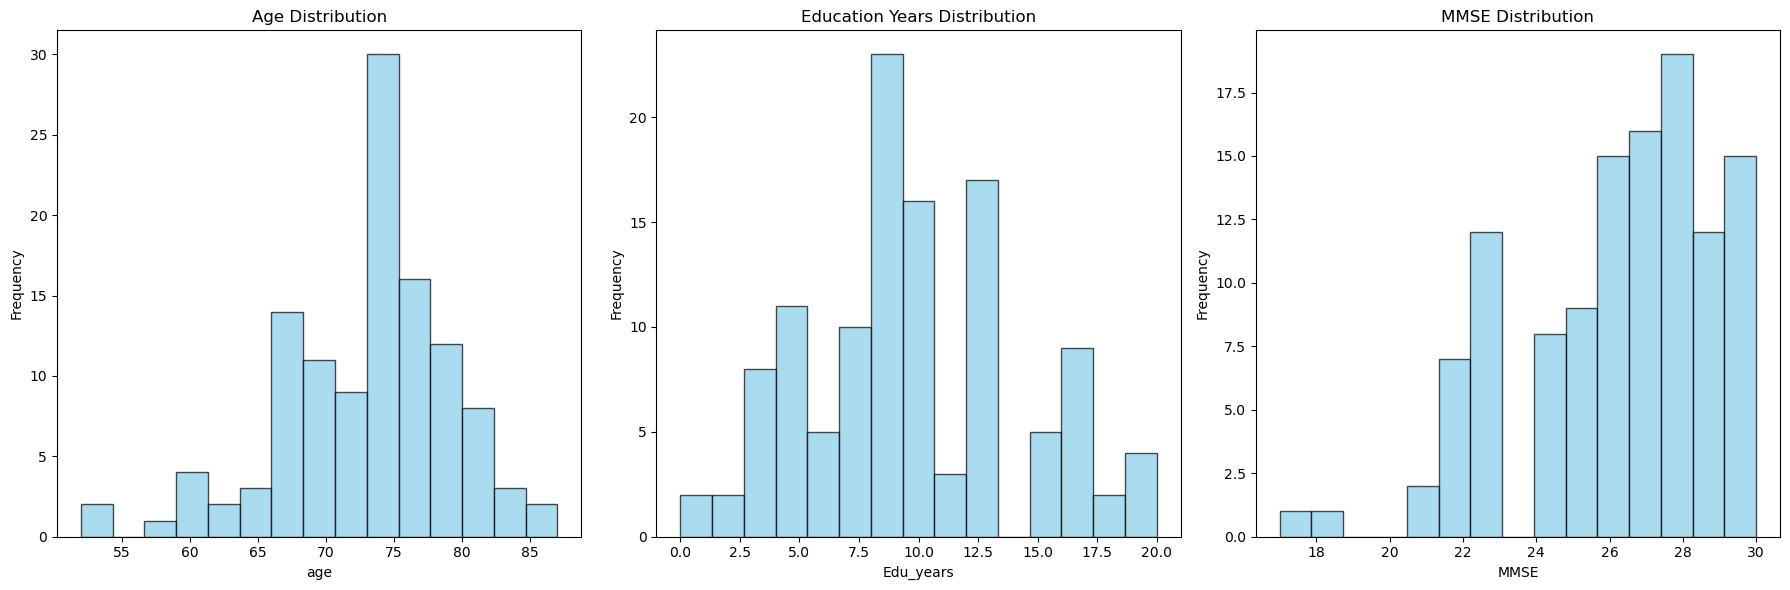

In [23]:
# Plot histograms for 'age', 'Edu_years', and 'MMSE' to visualize the distribution of each variable.
variables = ['age', 'Edu_years', 'MMSE']
titles = ['Age Distribution', 'Education Years Distribution', 'MMSE Distribution']

plt.figure(figsize=(18, 6))
for i, var in enumerate(variables):
    plt.subplot(1, 3, i+1)
    plt.hist(subject_converter_df[var], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(titles[i])
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('./figures/histograms_age_education_mmse.png', dpi=300)
#plt.show()


In [24]:
# Group by Site (CTB and CBU)
ctb = subject_converter_df[subject_converter_df['site'] == 'CTB']
cbu = subject_converter_df[subject_converter_df['site'] == 'CBU']

# Create an empty DataFrame for Table 1
table_1 = pd.DataFrame(columns=['Data characteristic', 'CTB', 'CBU', 'T/χ2 and p-value'])

# Helper function to append rows to the DataFrame using pd.concat
def append_row(df, row_dict):
    return pd.concat([df, pd.DataFrame([row_dict])], ignore_index=True)

# 1. Converters (using chi-square test)
conv_ctb = ctb['Converters'].value_counts().reindex([1.0, 0.0], fill_value=0)
conv_cbu = cbu['Converters'].value_counts().reindex([1.0, 0.0], fill_value=0)
conv_table = pd.DataFrame({'CTB': conv_ctb, 'CBU': conv_cbu})

chi2_conv, p_conv, _, _ = stats.chi2_contingency(conv_table.T)

table_1 = append_row(table_1, {
    'Data characteristic': 'Converters (1.0/0.0)',
    'CTB': f"1.0: {conv_ctb[1.0]}, 0.0: {conv_ctb[0.0]}",
    'CBU': f"1.0: {conv_cbu[1.0]}, 0.0: {conv_cbu[0.0]}",
    'T/χ2 and p-value': f"χ2={chi2_conv:.2f}, p={p_conv:.3f}"
})

# 2. Sex (M/F) (using chi-square test)
sex_ctb = ctb['sex'].value_counts().reindex(['M', 'F'], fill_value=0)
sex_cbu = cbu['sex'].value_counts().reindex(['M', 'F'], fill_value=0)
sex_table = pd.DataFrame({'CTB': sex_ctb, 'CBU': sex_cbu})

chi2_sex, p_sex, _, _ = stats.chi2_contingency(sex_table.T)

table_1 = append_row(table_1, {
    'Data characteristic': 'Sex (M/F)',
    'CTB': f"M: {sex_ctb['M']}, F: {sex_ctb['F']}",
    'CBU': f"M: {sex_cbu['M']}, F: {sex_cbu['F']}",
    'T/χ2 and p-value': f"χ2={chi2_sex:.2f}, p={p_sex:.3f}"
})

# 3. Age (years) (using t-test)
age_ctb_mean = ctb['age'].mean()
age_cbu_mean = cbu['age'].mean()
t_age, p_age = stats.ttest_ind(ctb['age'], cbu['age'], nan_policy='omit')

table_1 = append_row(table_1, {
    'Data characteristic': 'Age (years)',
    'CTB': f"{age_ctb_mean:.2f} ± {ctb['age'].std():.2f}",
    'CBU': f"{age_cbu_mean:.2f} ± {cbu['age'].std():.2f}",
    'T/χ2 and p-value': f"t={t_age:.2f}, p={p_age:.5f}"
})

# 4. Education (years) (using t-test)
edu_ctb_mean = ctb['Edu_years'].mean()
edu_cbu_mean = cbu['Edu_years'].mean()
t_edu, p_edu = stats.ttest_ind(ctb['Edu_years'], cbu['Edu_years'], nan_policy='omit')

table_1 = append_row(table_1, {
    'Data characteristic': 'Education (years)',
    'CTB': f"{edu_ctb_mean:.2f} ± {ctb['Edu_years'].std():.2f}",
    'CBU': f"{edu_cbu_mean:.2f} ± {cbu['Edu_years'].std():.2f}",
    'T/χ2 and p-value': f"t={t_edu:.2f}, p={p_edu:.6f}"
})

# 5. Baseline MMSE (using t-test)
mmse_ctb_mean = ctb['MMSE'].mean()
mmse_cbu_mean = cbu['MMSE'].mean()
t_mmse, p_mmse = stats.ttest_ind(ctb['MMSE'], cbu['MMSE'], nan_policy='omit')

table_1 = append_row(table_1, {
    'Data characteristic': 'Baseline MMSE',
    'CTB': f"{mmse_ctb_mean:.2f} ± {ctb['MMSE'].std():.2f}",
    'CBU': f"{mmse_cbu_mean:.2f} ± {cbu['MMSE'].std():.2f}",
    'T/χ2 and p-value': f"t={t_mmse:.2f}, p={p_mmse:.4f}"
})

# Show the resulting table
print(table_1)


    Data characteristic               CTB              CBU  \
0  Converters (1.0/0.0)  1.0: 41, 0.0: 49  1.0: 23, 0.0: 4   
1             Sex (M/F)      M: 35, F: 55     M: 17, F: 10   
2           Age (years)      73.99 ± 4.87     68.74 ± 8.48   
3     Education (years)       8.43 ± 4.47     13.02 ± 2.88   
4         Baseline MMSE      26.44 ± 2.64     25.70 ± 3.10   

      T/χ2 and p-value  
0    χ2=11.61, p=0.001  
1     χ2=3.95, p=0.047  
2    t=4.07, p=0.00009  
3  t=-5.02, p=0.000002  
4     t=1.22, p=0.2242  


In [25]:
# compute dispersion indices for recording year

grouped_df = subject_converter_df.groupby('Converters')

# Compute the statistics for each group
summary_stats = grouped_df['Recording_year'].agg(
    mean='mean',
    std_dev='std',
    min_value='min',
    max_value='max'
)

# Calculate the range (max - min)
summary_stats['range'] = summary_stats['max_value'] - summary_stats['min_value']

print(summary_stats)


                   mean   std_dev  min_value  max_value  range
Converters                                                    
0.0         2011.113208  0.824163       2009       2012      3
1.0         2011.750000  1.817027       2009       2016      7


# Analysis PSD


In [13]:
feature_mmse = list(subject_df['MMSE'])
feature_control = [ 1 if is_control else 0 for is_control in subject_df['group'] == 'control']
feature_converter = subject_df['Converters'].fillna(-1)

In [14]:
psds = np.array([features_all[subject][1] for subject in features_all]) # 0 cov, 1 pow, 2 csd
psds = 10*np.log10(psds) #dB
psds_mean_chan = np.mean(psds, 1) #mean over channels
psds_mean_chan.shape

(323, 121)

In [15]:
del features_all, features_CBU, features_CTB1, features_CTB2

## Plot mean psd by group (converter vs nonconverter)

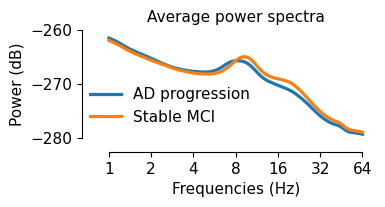

In [16]:
plt.rcParams['font.size'] = 11
fig, axes = plt.subplots(1,1, figsize=[3.6,1.4],sharey=True)
psd_mean_converter = np.mean(psds_mean_chan[np.array(feature_converter) == 1],0)
psd_mean_non_converter = np.mean(psds_mean_chan[np.array(feature_converter) == 0],0)

plt.plot(foi, psd_mean_converter, label='AD progression', linewidth = 2.3)
plt.plot(foi, psd_mean_non_converter, label = 'Stable MCI', linewidth = 2.3)

legend = plt.legend(loc='upper right', bbox_to_anchor=(0.6, 0.6))
frame = legend.get_frame()
frame.set_linewidth(0) 
plt.title('Average power spectra', fontsize=11, y=1)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Power (dB)')
plt.ylim(-280,-260)
plt.xscale('log', base =2)
plt.xticks([1,2,4,8,16,32,64],labels = [1,2,4,8,16,32,64])
#plt.xticks(plt.xticks()[0][2:-2], labels = [1,2,4,8,16,32,64])
sns.despine(offset=10, trim=True);
plt.savefig('./figures/figure1a.pdf', dpi=300, bbox_inches='tight')

## ADJUST FOR CONVERTERS

In [18]:
subject_df_adjust3 = subject_df.copy()
subject_df_adjust3['Converters'] = subject_df_adjust3['Converters'].fillna(-1)
subject_df_adjust3.loc[subject_df_adjust3['Converters'] >= 0].index.to_numpy()
converters_idx = subject_df_adjust3['Converters'] >= 0
psds_mean_chan[converters_idx].shape

(117, 121)

In [19]:
psds_clean_converter = psds[converters_idx]
psds_clean_mean_converter = np.mean(psds_clean_converter, 1)

## T-test to compare mean PSD between groups (converters vs non converters) at definite frequencies

In [ ]:
# T test to compare mean psd between groups at definite frequencies (2, 4, 8, 16, 32Hz)
psds_mean_channels_converters_all = np.mean((psds_clean_converter[:,:,20:120:20]),1)
psds_mean_channels_converters = psds_mean_channels_converters_all[np.array(feature_converter[converters_idx]) == 1]
psds_mean_channels_nonconverters = psds_mean_channels_converters_all[np.array(feature_converter[converters_idx]) == 0]
t_statistic, p_value_conv = ttest_ind(psds_mean_channels_converters, psds_mean_channels_nonconverters, axis=0, equal_var=False)
print(p_value_conv*5)


[1.38807299 1.60743906 4.85140523 0.02348687 0.0099091 ]


In [ ]:
psdsT = psds_clean_converter.transpose(0,2,1) # converter/non

In [22]:
psds_mean_channels_converters_all.shape
np.mean(psdsT[feature_converter[converters_idx] == 0],2).shape

psds_clean_mean_converter[np.array(feature_converter[feature_converter >= 0]) == 1].shape
psds_clean_mean_converter[np.array(feature_converter[feature_converter >= 0]) == 0].shape

(53, 121)

In [23]:
psdsT.shape

(117, 121, 102)

## Permutation F-test on sensor data averaged over all sensors

In [24]:
data_condition_1 = psds_clean_mean_converter[np.array(feature_converter[feature_converter >= 0]) == 0]
data_condition_2 = psds_clean_mean_converter[np.array(feature_converter[feature_converter >= 0]) == 1]

# Prepare your data for cluster-based permutation test
X = [data_condition_1, data_condition_2]

In [25]:
data_condition_2.shape

(64, 121)

## TFCE F-test method to compare averaged metrics between groups


In [26]:
np.mean(psdsT[feature_converter[converters_idx] == 1],2).shape 

(64, 121)

In [ ]:
T_obs, clusters, cluster_p_values, H0 = mne.stats.permutation_cluster_test([data_condition_2,data_condition_1], 
                                                                           threshold = dict (start = 0, step = 0.2),
                                                                           n_jobs = None, n_permutations = 10000, 
                                                                           tail=0, 
                                                                           out_type="mask")
print(clusters, cluster_p_values)
print(T_obs)

stat_fun(H1): min=0.001368 max=13.866833
Running initial clustering …
Using 70 thresholds from 0.00 to 13.80 for TFCE computation (h_power=2.00, e_power=0.50)
Found 121 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

[slice(0, 1, None), slice(1, 2, None), slice(2, 3, None), slice(3, 4, None), slice(4, 5, None), slice(5, 6, None), slice(6, 7, None), slice(7, 8, None), slice(8, 9, None), slice(9, 10, None), slice(10, 11, None), slice(11, 12, None), slice(12, 13, None), slice(13, 14, None), slice(14, 15, None), slice(15, 16, None), slice(16, 17, None), slice(17, 18, None), slice(18, 19, None), slice(19, 20, None), slice(20, 21, None), slice(21, 22, None), slice(22, 23, None), slice(23, 24, None), slice(24, 25, None), slice(25, 26, None), slice(26, 27, None), slice(27, 28, None), slice(28, 29, None), slice(29, 30, None), slice(30, 31, None), slice(31, 32, None), slice(32, 33, None), slice(33, 34, None), slice(34, 35, None), slice(35, 36, None), slice(36, 37, None), slice(37, 38, None), slice(38, 39, None), slice(39, 40, None), slice(40, 41, None), slice(41, 42, None), slice(42, 43, None), slice(43, 44, None), slice(44, 45, None), slice(45, 46, None), slice(46, 47, None), slice(47, 48, None), slice(48, 

In [28]:
print(clusters, cluster_p_values)

[slice(0, 1, None), slice(1, 2, None), slice(2, 3, None), slice(3, 4, None), slice(4, 5, None), slice(5, 6, None), slice(6, 7, None), slice(7, 8, None), slice(8, 9, None), slice(9, 10, None), slice(10, 11, None), slice(11, 12, None), slice(12, 13, None), slice(13, 14, None), slice(14, 15, None), slice(15, 16, None), slice(16, 17, None), slice(17, 18, None), slice(18, 19, None), slice(19, 20, None), slice(20, 21, None), slice(21, 22, None), slice(22, 23, None), slice(23, 24, None), slice(24, 25, None), slice(25, 26, None), slice(26, 27, None), slice(27, 28, None), slice(28, 29, None), slice(29, 30, None), slice(30, 31, None), slice(31, 32, None), slice(32, 33, None), slice(33, 34, None), slice(34, 35, None), slice(35, 36, None), slice(36, 37, None), slice(37, 38, None), slice(38, 39, None), slice(39, 40, None), slice(40, 41, None), slice(41, 42, None), slice(42, 43, None), slice(43, 44, None), slice(44, 45, None), slice(45, 46, None), slice(46, 47, None), slice(47, 48, None), slice(48, 

In [29]:
print(foi[cluster_p_values<0.05])

[16.         16.56423878 17.1483754  17.75311155 18.37917368 19.02731384
 19.69831061 20.39297004 21.11212657 21.85664411 22.627417   23.42537114
 24.25146506 25.10669113 25.99207668 26.90868529 27.85761803 28.8400148
 29.85705573 30.90996253 32.         33.12847756 34.2967508  35.50622311
 36.75834736 38.05462768 39.39662123]


### Vizualization

In [30]:
rng = np.random.RandomState(23)

def my_statistic(sample1, sample2, axis=0):
    statistic = np.mean(sample1) - np.mean(sample2)
    return statistic

condition1 = np.mean(psdsT[feature_converter[converters_idx] == 0], 2)
condition2 = np.mean(psdsT[feature_converter[converters_idx] == 1], 2)
#condition1=data_condition_1
#condition2=data_condition_2

results = list()

for ii in range(condition2.shape[1]):
    data = (condition2[:, ii], condition1[:, ii])
    res = bootstrap(data, my_statistic, method='basic', random_state=rng, vectorized=False)
    results.append(res)    

conf_ints = np.array([tuple(res.confidence_interval) for res in results])
conf_ints.shape
                    

(121, 2)

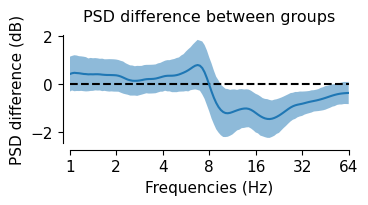

In [ ]:
plt.rcParams['font.size'] = 11


# mean PSD difference
mean_difference = condition2.mean(axis=0) - condition1.mean(axis=0)

# IC95 for the difference
upper_bound = conf_ints[:,1]
lower_bound = conf_ints[:,0]

fig, ax = plt.subplots(1, 1, figsize=[3.6,1.4], sharey=True)
ax.set_title('PSD difference between groups', fontsize = 11.5, y=1.05)
ax.set_xscale('log', base=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
xticks = [1, 2, 4, 8, 16, 32, 64]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
#ax.set_ylim(-1, 1.7)
ax.set_xlim(1, 64)
ax.axhline(0, color='black', linestyle= "--")
sns.despine(offset=5, trim=False)

# Plot the mean difference
line = ax.plot(
    foi,
    mean_difference,
    label="Mean Difference"
)

# Fill the area between upper and lower CI bounds
ax.fill_between(foi,upper_bound, lower_bound, alpha=0.5, label="95% CI")

ax.set_ylabel("PSD difference (dB)")
ax.set_xlabel("Frequencies (Hz)")

plt.savefig('./figures/figure1b.pdf', bbox_inches='tight')

## Visualisation

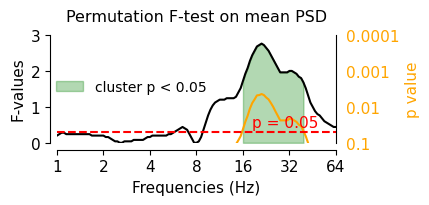

In [32]:
mask = cluster_p_values <= 0.05

plt.rcParams['font.size'] = 11
fig, ax2 = plt.subplots(1, 1, figsize=[3.6, 1.4], sharey=True)
ax2.set_title('Permutation F-test on mean PSD', fontsize = 11.5, y=1.05)

# Plot the main black line
hf, = ax2.plot(foi, T_obs, "black")

# Find contiguous regions of significant frequencies
inside_cluster = False
for i in range(len(foi)):
    if mask[i] and not inside_cluster:
        start_idx = i
        inside_cluster = True
    elif not mask[i] and inside_cluster:
        end_idx = i
        # Fill between for this cluster region
        ax2.fill_between(foi[start_idx:end_idx], y1=T_obs[start_idx:end_idx], y2=0, 
                         color="green", label='cluster p < 0.05', alpha=0.3)
        inside_cluster = False

# If a cluster goes till the end of the data
if inside_cluster:
    ax2.fill_between(foi[start_idx:], y1=T_obs[start_idx:], y2=0, color="green", alpha=0.3)

# Set axes labels and scales
ax2.set_xlabel("Frequencies (Hz)")
ax2.set_ylabel("F-values")
ax2.set_xscale('log', base=2)
xticks = [1, 2, 4, 8, 16, 32, 64]
ax2.set_xticks(xticks)
ax2.set_xlim(1, 64)
ax2.set_ylim(0,3)
ax2.set_xticklabels(xticks)

# #
axes2 = ax2.twinx()
axes2.plot(foi, -np.log10(cluster_p_values), color='orange')
axes2.set_ylabel('p value', color='orange')
axes2.set_ylim(1, 4)
axes2.axhline(-np.log10(0.05), color='red', linestyle='--')
axes2.annotate(xy=(0.7, 0.14), text='p = 0.05', color='r', xycoords='axes fraction')
axes2.set_yticks(-np.log10([0.1, 0.01, 0.001, 0.0001]))
axes2.set_yticklabels([0.1, 0.01, 0.001, 0.0001], color='orange')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
sns.despine(offset=5, trim=False, ax=ax2)
sns.despine(right=False, left=True, top=True, bottom=True, ax=axes2)

ax2.legend(loc='upper right', bbox_to_anchor=(0.58, 0.7), ncol=2, fontsize=10, frameon=False)

plt.savefig('./figures/figure1c.pdf', bbox_inches='tight')

### CLUSTER BASED PERMUTATION TEST TO COMPARE TOPOMAPS BETWEEN GROUPS (keeping spatial info on 102 channels)

In [59]:
psds_converters = psds_clean_mean_converter[feature_converter[converters_idx] == 1] # psd array adjusted for converters
psds_nonconverters = psds_clean_mean_converter[feature_converter[converters_idx] == 0]

In [60]:
psds_clean_mean_converter.shape

(117, 121)

In [61]:
psdsT = psds_clean_converter.transpose(0,2,1)

In [62]:
psdsT[feature_converter[converters_idx] == 0].shape

(53, 121, 102)

In [ ]:
# cluster permutation test with TFCE keeping channel info and frequencies info.
F, c, alpha, h = mne.stats.spatio_temporal_cluster_test(
    [psdsT[feature_converter[converters_idx] == 0],
     psdsT[feature_converter[converters_idx] == 1]],
     threshold = dict (start=0, step=0.2), 
    n_jobs = 4, n_permutations = 10000, tail=0, adjacency=adj_matrix)
print(alpha)

stat_fun(H1): min=0.000000 max=28.655871
Running initial clustering …
Using 144 thresholds from 0.00 to 28.60 for TFCE computation (h_power=2.00, e_power=0.50)
Found 12342 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

[0.929  0.667  0.8794 ... 0.9999 1.     1.    ]


In [77]:
# c has shape 29*102=2958 (tuple : (freq, chan)), each tuple will be called cl
# alpha has shape 29*102=2958,containing pvalues
p_clust = np.zeros((psdsT.shape[1],psdsT.shape[2])) # init p_clust, shape freq, channels
for cl, p in zip(c, alpha): # fills in p_clust array 
    p_clust[cl]=-np.log10(p)
p_clust.shape
mask = np.ones_like(p_clust, dtype = bool)
mask[p_clust<1.3] = False
# will enable to create topomaps of p values for each frequency for each channel

In [78]:
idx_15_5_post = np.where(mask[79,:])[0]
idx_19_post = np.where(mask[85,:])[0]
idx_23_post = np.where(mask[91,:])[0]
idx_28_post = np.where(mask[97,:])[0]
idx_35_post = np.where(mask[103,:])[0]

In [68]:
idx = np.where(mask.sum(axis=1)>4)[0]  # indicates frequencies with more than 5 significant sensors
foi[idx]
print(foi[idx[::6]]) # utilise un pas de 6

[ 9.51365692 11.71268557 14.4200074  17.75311155 21.85664411 26.90868529
 33.12847756 40.78594007 50.21338227 61.81992505]


In [69]:
psds_converters = psds_clean_converter[feature_converter[converters_idx] == 1]
psds_nonconverters = psds_clean_converter[feature_converter[converters_idx] == 0]
psds_converters_mean = np.mean(psds_converters, 0)
psds_nonconverters_mean = np.mean(psds_nonconverters, 0)

## PLOT TOPOMAPS FOR CONVERTERS VS NON CONVERTERS DIFF

## Plot function

In [71]:
def topoplot(    
    data,  # 1D array or list with values corresponding to the channels in channel_names
    channel_names, # list of channel names, e.g. ["Fp1", "Fp2", ...]
    info,  
    montage = "standard_1020",
    cmap='RdBu_r',
    scale_limits=(None, None),  # useful to plot several topographies on the same scale
    size=1,  # size of the topoplot
    axes=None,
    mask=None,
):
    assert len(data) == len(channel_names)

    _, pos, _, _, ch_type, sphere_, clip_origin = _prepare_topomap_plot(
        info,
        "mag",
        sphere=(0, 0.023, 0.021, 0.1)
    )
    
    outlines_ = _make_head_outlines(sphere_, pos, 'head', clip_origin)
    
    im, cn = mne.viz.plot_topomap(
        data=data, 
        pos=pos, 
        axes=axes,
        vlim = scale_limits,
        cmap=cmap,
        outlines=outlines_,
        image_interp='cubic',
        size=size,
        mask=mask,
        show=False,
    )

    return im, cn

def plot_topoplot_grid(
    data, # data[i][j] contains a 1D list or array with data for the topo plot in row i and col j
    info, 
    row_labels,  # list of row labels that describe the rows in data, e.g. ["Condition 1", "Condition 2"]
    col_labels,  # list of col labels that describe the cols in data, e.g. ["Alpha" ,"Beta", "Gamma"]
    channel_names,  # channel labels in corresponding order to the 1D lists or arrays in data
    cbar_mode="single",  # "single" for shared scale, "each" for individual scales
    cbar_label=r"$10\times\log_{10}fT^2/Hz$[dB]",  # label for the color bar,
    #cbar_label=r"dB",
    cmap='RdBu_r',
    scale_limits=(None, None),
    mask=None,
):
    # Figure Grid Params
    x_label_size=12
    y_label_size=12
    x_label_pad=10
    y_label_pad=10
    
    cbar_fmt='%3.2f'
    cbar_size="5%"
    cbar_pad=0.1 if cbar_mode == "each" else 0.8
    axes_pad=(0.9 if cbar_mode == "each" else 0.4 , 0.4)
    clabel_size=10
    fig_size=(12, 4)
    rect=(0.05, 0.05, 0.90, 0.95)

    nrows = len(data)
    ncols = len(data[0])

    fig = plt.figure(figsize=fig_size)
    grid = ImageGrid(
        fig, rect,
        nrows_ncols=(nrows, ncols),
        axes_pad=axes_pad, share_all=True, cbar_location="right",
        cbar_mode=cbar_mode, cbar_size=cbar_size, cbar_pad=cbar_pad,
    )

    
    if cbar_mode == "single" and scale_limits == (None, None):
        scale_limits = np.array(data).min(), np.array(data).max()
    elif cbar_mode == "each" and scale_limits == "columns":
        mins = np.min(np.hstack(data), axis=1)
        maxs = np.max(np.hstack(data), axis=1)
 
    scale_limits_ = scale_limits
    axes = grid.axes_row
    for row, row_label in enumerate(row_labels):
        for col, col_label in enumerate(col_labels):
            ax = axes[row][col]
            if cbar_mode == "each" and scale_limits == "columns":
                scale_limits_ = [mins[col], maxs[col]]
            im, _ = topoplot(data[row][col], channel_names, info, scale_limits=scale_limits_,
                             axes=ax,
                             cmap=cmap,
                             mask= None if mask is None else mask[row][col])

            ax.set_xlabel(col_label, fontsize=x_label_size, labelpad=x_label_pad)
            ax.set_ylabel(row_label, fontsize=y_label_size, labelpad=y_label_pad)

            cbar = ax.cax.colorbar(im)
            cbar.ax.set_ylabel(cbar_label, fontsize=clabel_size)
            ax.cax.toggle_label(True)
     
    return fig

In [73]:
def min_max(c):
    this_min, this_max = np.min(c), np.max(c)
    my_max = max(abs(this_min), abs(this_max))
    return my_max

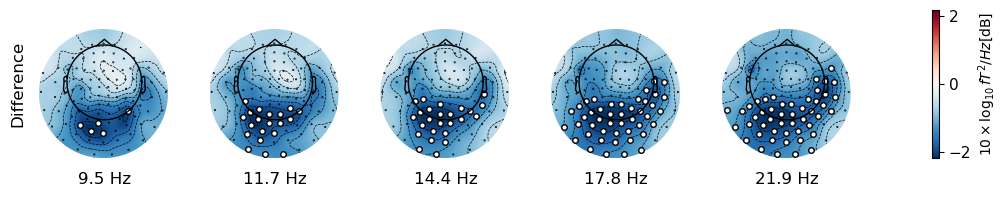

In [75]:
difference = np.squeeze(np.array([psds_converters_mean - psds_nonconverters_mean]))

data_diff = [
    [difference[:, ix] for ix in idx[::6][:5]],
]
mask_grid = [
    [mask.T[:, ix] for ix in idx[::6][:5]],
]
row_labels = ["Difference"]
col_labels = [f"{f:0.1f} Hz" for f in foi[idx[::6][:5]]]
channel_names = raw_for_adjacency.info.ch_names

fig = plot_topoplot_grid(data_diff, raw_for_adjacency.info, row_labels, col_labels, channel_names, scale_limits = [lambda x: -min_max(x), min_max],
                         cbar_mode="single", mask=mask_grid,
                         );
fig.set_size_inches(10, 2)
plt.savefig('./figures/figure1_topoplot_diff_top.pdf', bbox_inches='tight')

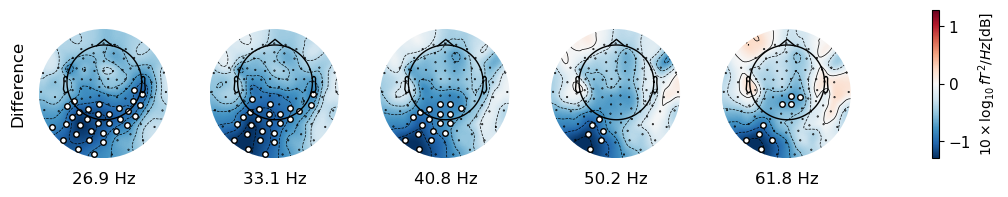

In [76]:
difference = np.squeeze(np.array([psds_converters_mean - psds_nonconverters_mean]))

data_diff = [
    [difference[:, ix] for ix in idx[::6][5:]],
]
mask_grid = [
    [mask.T[:, ix] for ix in idx[::6][5:]],
]
row_labels = ["Difference"]
col_labels = [f"{f:0.1f} Hz" for f in foi[idx[::6][5:]]]
channel_names = raw_for_adjacency.info.ch_names

fig = plot_topoplot_grid(data_diff, raw_for_adjacency.info, row_labels, col_labels, channel_names, scale_limits = [lambda x: -min_max(x), min_max],
                         cbar_mode="single", mask=mask_grid,
                         );
fig.set_size_inches(10, 2)
plt.savefig('./figures/figure1_topoplot_diff_bot.pdf', bbox_inches='tight')